In [28]:

import os
import torch
import gc
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import albumentations as A
import torch.nn.functional as F
import torch.nn as nn
import numpy as np

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensorV2

device = "cuda" if torch.cuda.is_available() else "cpu"

Downloading...
From (original): https://drive.google.com/u/0/uc?id=1k-u4hPlhqzw5NDUxq9_erhTJkZEM3U3s
From (redirected): https://drive.google.com/uc?id=1k-u4hPlhqzw5NDUxq9_erhTJkZEM3U3s&confirm=t&uuid=34a7de0a-0f73-4917-af2f-e820361bf948
To: c:\Users\domin\OneDrive\Desktop\ProjektSG-GAN\maps.zip

  0%|          | 0.00/252M [00:00<?, ?B/s]
  1%|▏         | 3.15M/252M [00:00<00:08, 31.0MB/s]
  4%|▍         | 9.44M/252M [00:00<00:04, 49.5MB/s]
  7%|▋         | 17.3M/252M [00:00<00:03, 59.4MB/s]
 10%|█         | 26.2M/252M [00:00<00:03, 70.6MB/s]
 14%|█▎        | 34.1M/252M [00:00<00:03, 64.5MB/s]
 18%|█▊        | 44.6M/252M [00:00<00:02, 76.7MB/s]
 22%|██▏       | 55.6M/252M [00:00<00:02, 86.4MB/s]
 26%|██▋       | 66.6M/252M [00:00<00:02, 92.4MB/s]
 31%|███       | 77.6M/252M [00:00<00:01, 97.3MB/s]
 35%|███▌      | 88.1M/252M [00:01<00:01, 98.4MB/s]
 39%|███▉      | 98.6M/252M [00:01<00:01, 99.1MB/s]
 44%|████▎     | 110M/252M [00:01<00:01, 102MB/s]  
 48%|████▊     | 120M/252M [00:01<00

In [3]:
!7z x maps.zip


'7z' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
!ls maps


'ls' is not recognized as an internal or external command,
operable program or batch file.


In [17]:
class ImageFolderDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_files = [f for f in os.listdir(folder_path) if f.endswith(".jpg")]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.folder_path, self.image_files[idx])
        image = Image.open(img_path)
        width, height = image.size
        half_width = width // 2
        left_image = image.crop((0, 0, half_width, height))
        right_image = image.crop((half_width, 0, width, height))

        if self.transform:
            transformed = self.transform(image=np.array(left_image), image0=np.array(right_image))
            left_image, right_image = transformed['image'], transformed['image0']

        return left_image, right_image

In [18]:
# [-1, 1]
def normalize(x, **kwargs):
    return ((x / 127.5) - 1).astype(np.float32)

# [-1, 1]
def denormalize(x, **kwargs):
    # return torch.clamp((x + 1) * 255 / 2, 0, 255).to(torch.uint8)
    return torch.clamp(((x * 255.0) + 255) / 2, 0, 255).to(torch.uint8)

# [0, 1]
# def normalize(x, **kwargs):
#     return (x / 255.0).astype(np.float32)

# [0, 1]
# def denormalize(x, **kwargs):
#     return torch.clamp(x * 255, 0, 255).to(torch.uint8)

# https://albumentations.ai/docs/api_reference/augmentations/
transform = A.Compose([
    # A.ColorJitter(p=0.3),
    A.Resize(256, 256),
    # A.Rotate(limit=40),
    A.Lambda(image=normalize),
    ToTensorV2(),
], additional_targets={'image0': 'image'})

In [19]:
train_path = 'maps/train'
valid_path = 'maps/val'
train_batch_size = 10
valid_batch_size = 2

dataset_train = ImageFolderDataset(train_path, transform=transform)
dataset_valid = ImageFolderDataset(valid_path, transform=transform)

dataloader_train = DataLoader(dataset_train, batch_size=train_batch_size, shuffle=False)
dataloader_valid = DataLoader(dataset_valid, batch_size=valid_batch_size, shuffle=False)

In [20]:
def show_images(left_images, right_images, title=None):
    fig, axes = plt.subplots(len(left_images), 2, figsize=(5, 5))
    for i, (left_img, right_img) in enumerate(zip(left_images, right_images)):
        left_img = left_img.permute(1, 2, 0)
        right_img = right_img.permute(1, 2, 0)
        axes[i, 0].imshow(left_img)
        axes[i, 1].imshow(right_img)
        axes[i, 0].axis('off')
        axes[i, 1].axis('off')
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    if title is not None:
        fig.suptitle(f"{title}")
    plt.show()

torch.Size([2, 3, 256, 256])


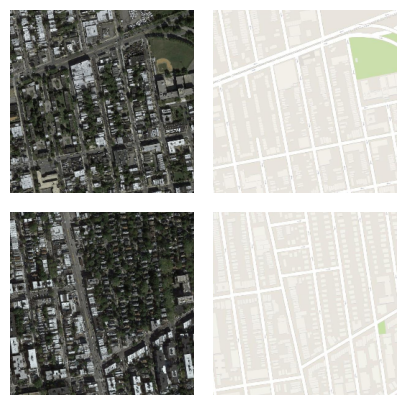

In [21]:
images = next(iter(dataloader_valid))
left_images, right_images = images
print(left_images.shape)
left_images = denormalize(left_images)
right_images = denormalize(right_images)
show_images(left_images, right_images)

In [22]:

def show_images3(left_images, center_images, right_images, title=None):
    fig, axes = plt.subplots(len(left_images), 3, figsize=(7.5, 5))
    for i, (left_img, center_img, right_img) in enumerate(zip(left_images, center_images, right_images)):
        left_img = left_img.permute(1, 2, 0)
        center_img = center_img.permute(1, 2, 0)
        right_img = right_img.permute(1, 2, 0)
        axes[i, 0].imshow(left_img)
        axes[i, 1].imshow(center_img)
        axes[i, 2].imshow(right_img)
        axes[i, 0].axis('off')
        axes[i, 1].axis('off')
        axes[i, 2].axis('off')
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    if title is not None:
        fig.suptitle(f"{title}")
    plt.show()


torch.Size([2, 3, 256, 256])


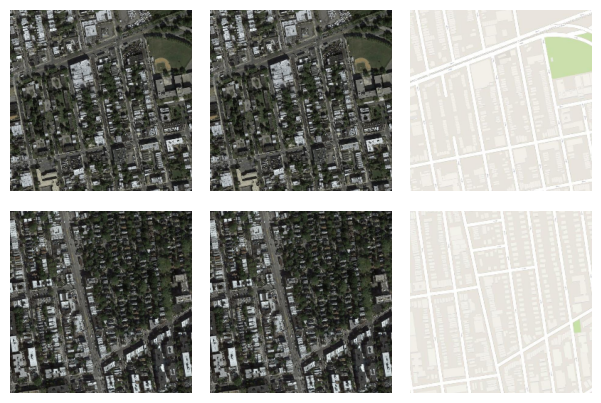

In [23]:
images = next(iter(dataloader_valid))
left_images, right_images = images
print(left_images.shape)
left_images = denormalize(left_images)
right_images = denormalize(right_images)
show_images3(left_images,left_images, right_images)

In [24]:
gc.collect()
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [25]:
class UNetGenerator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(UNetGenerator, self).__init__()
        
        def down_block(in_channels, out_channels, use_dropout=False):
            layers = [
                nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.2, inplace=True)
            ]
            if use_dropout:
                layers.append(nn.Dropout(0.5))
            return nn.Sequential(*layers)

        def up_block(in_channels, out_channels, use_dropout=False):
            layers = [
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            ]
            if use_dropout:
                layers.append(nn.Dropout(0.5))
            return nn.Sequential(*layers)

        self.down1 = down_block(in_channels, 64)
        self.down2 = down_block(64, 128)
        self.down3 = down_block(128, 256)
        self.down4 = down_block(256, 512, use_dropout=True)
        self.down5 = down_block(512, 512, use_dropout=True)
        self.down6 = down_block(512, 512, use_dropout=True)
        self.down7 = down_block(512, 512, use_dropout=True)
        self.down8 = down_block(512, 512)

        self.up1 = up_block(512, 512, use_dropout=True)
        self.up2 = up_block(1024, 512, use_dropout=True)
        self.up3 = up_block(1024, 512, use_dropout=True)
        self.up4 = up_block(1024, 512)
        self.up5 = up_block(1024, 256)
        self.up6 = up_block(512, 128)
        self.up7 = up_block(256, 64)
        self.up8 = nn.ConvTranspose2d(128, out_channels, kernel_size=4, stride=2, padding=1, bias=False)
        self.final = nn.Tanh()

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)

        u1 = self.up1(d8)
        u2 = self.up2(torch.cat([u1, d7], 1))
        u3 = self.up3(torch.cat([u2, d6], 1))
        u4 = self.up4(torch.cat([u3, d5], 1))
        u5 = self.up5(torch.cat([u4, d4], 1))
        u6 = self.up6(torch.cat([u5, d3], 1))
        u7 = self.up7(torch.cat([u6, d2], 1))
        u8 = self.up8(torch.cat([u7, d1], 1))
        
        return self.final(u8)


In [26]:

class PatchGANDiscriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(PatchGANDiscriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, stride, normalize=True):
            layers = [nn.Conv2d(in_filters, out_filters, kernel_size=4, stride=stride, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return nn.Sequential(*layers)

        self.model = nn.Sequential(
            discriminator_block(in_channels * 2, 64, stride=2, normalize=False),
            discriminator_block(64, 128, stride=2),
            discriminator_block(128, 256, stride=2),
            discriminator_block(256, 512, stride=1),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)
        )

    def forward(self, img_A, img_B):
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

In [ ]:
generator = UNetGenerator().to(device)
discriminator = PatchGANDiscriminator().to(device)
criterion_GAN = nn.BCEWithLogitsLoss().to(device)
criterion_L1 = nn.L1Loss().to(device)
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))
save_dir = 'models'
os.makedirs(save_dir, exist_ok=True)

In [ ]:
generator_path = os.path.join('models', 'spade_generator.pth')
discriminator_path = os.path.join('models', 'spade_discriminator.pth')
if os.path.exists(generator_path):
    generator.load_state_dict(torch.load(generator_path, map_location=torch.device('cpu')))
    print(f"Loaded generator from {generator_path}")
else:
    print("No generator checkpoint found, starting from scratch.")

if os.path.exists(discriminator_path):
    discriminator.load_state_dict(torch.load(discriminator_path, map_location=torch.device('cpu')))
    print(f"Loaded discriminator from {discriminator_path}")
else:
    print("No discriminator checkpoint found, starting from scratch.")
num_epochs = 200

Loaded generator from models\spade_generator.pth
Loaded discriminator from models\spade_discriminator.pth
[Epoch 0/200] [Batch 0/110] [D loss: 0.0012448414927348495] [G loss: 38.39239501953125]


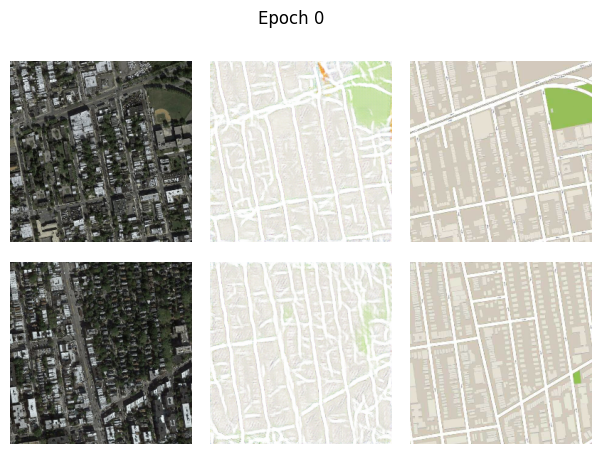

Saved generator to models\spade_generator.pth and discriminator to models\spade_discriminator.pth
[Epoch 0/200] [Batch 1/110] [D loss: 0.003138488158583641] [G loss: 22.486968994140625]
[Epoch 0/200] [Batch 2/110] [D loss: 0.0020632059313356876] [G loss: 16.638242721557617]
[Epoch 0/200] [Batch 3/110] [D loss: 0.05536424368619919] [G loss: 11.989049911499023]


KeyboardInterrupt: 

In [32]:

for epoch in range(num_epochs):
    generator.train()
    discriminator.train()
    
    for i, (left_images, right_images) in enumerate(dataloader_train):
        real_A = left_images.to(device)
        real_B = right_images.to(device)

        valid = torch.ones((real_A.size(0), 1, 30, 30), requires_grad=False).to(device)
        fake = torch.zeros((real_A.size(0), 1, 30, 30), requires_grad=False).to(device)

        
        #  Train Generator
        

        optimizer_G.zero_grad()

        fake_B = generator(real_A)

        pred_fake = discriminator(fake_B, real_A)
        loss_GAN = criterion_GAN(pred_fake, valid)
        loss_L1 = criterion_L1(fake_B, real_B)

        loss_G = loss_GAN + 100 * loss_L1
        loss_G.backward()
        optimizer_G.step()
       
        #  Train Discriminator

        optimizer_D.zero_grad()

        pred_real = discriminator(real_B, real_A)
        loss_real = criterion_GAN(pred_real, valid)

        pred_fake = discriminator(fake_B.detach(), real_A)
        loss_fake = criterion_GAN(pred_fake, fake)

        loss_D = 0.5 * (loss_real + loss_fake)
        loss_D.backward()
        optimizer_D.step()

        print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(dataloader_train)}] [D loss: {loss_D.item()}] [G loss: {loss_G.item()}]")

    # Validation loop
        if i % 55 == 0:
            generator.eval()
            val_sats, val_maps = next(iter(dataloader_valid))
            val_sats, val_maps = val_sats.to(device), val_maps.to(device)
            with torch.no_grad():
                generated_val_maps = generator(val_sats)
                show_images3(denormalize(val_sats.cpu()), denormalize(generated_val_maps.cpu()), val_maps.cpu(), title=f"Epoch {epoch}")
                # Save the model after each epoch
                torch.save(generator.state_dict(), generator_path)
                torch.save(discriminator.state_dict(), discriminator_path)
                print(f"Saved generator to {generator_path} and discriminator to {discriminator_path}")

